In [9]:
import math
import numpy as np

from src.options import GeometricBrownianMotion

from src.options import Option

def feature_maps(simulated_paths: list[list[float]],
                 K: float,
                 T: float,
                 num_paths: int,
                 num_steps: int) -> np.ndarray:
    # Нормализация симулированных путей относительно цены исполнения опциона
    S = np.array(simulated_paths).flatten() / K
    
    # Создание матрицы признаков для аппроксимации value function
    fs = np.vstack([
        np.ones_like(S), # константный
        np.exp(-S/2), 
        np.exp(-S/2) * (1 - S),
        np.exp(-S/2) * (1 - 2*S + 0.5*S*S)
    ])

    # Создание временных признаков
    t = np.arange(num_steps)
    dt = T / num_steps
    ft = np.vstack([
        np.sin(0.5 * math.pi * (1 - t/num_steps)),
        np.log(T - t*dt),
        (t / num_steps) ** 2
    ])
    # Добавление столбца для всех путей
    ft = np.hstack([ft, np.array([0, 0, 1]).reshape(3, 1)])
    ft = np.tile(ft, num_paths)

    # Комбинация признаков цен и времени
    return np.vstack([fs, ft])


def price_option(option: Option,
                 risk_free_rate: float,
                 volatility: float,
                 time_to_maturity_in_years: float,
                 num_paths: int = 5000,
                 num_steps: int = 50,
                 # for policy iteration
                 tol: float = 1e-6,
                 maxiter: int = 20,
                 seed: int | None = None) -> float:

    dt = time_to_maturity_in_years / num_steps
    drift = risk_free_rate - option.dividend_yield


    simulated_paths = GeometricBrownianMotion.simulate(
        init=option.underlying.spot_price,
        mu=drift,
        sigma=volatility,
        dt=dt,
        num_steps=num_steps,
        num_paths=num_paths,
        seed=seed
    )
    
    total_num_price_points = num_paths * (num_steps + 1) #!!!

    # [num of features x num_paths * (num_steps + 1)]
    phi = feature_maps(
        simulated_paths=simulated_paths,
        K=option.strike_price,
        T=time_to_maturity_in_years,
        num_paths=num_paths,
        num_steps=num_steps
    )
    # print(phi.shape) (7, 10000)
    assert phi.shape[1] == total_num_price_points

    # Вычисление выплат по опционам
    payoffs = np.array([
        option.payoff(S, time_to_maturity_in_years - t*dt)
        for path in simulated_paths for (t, S) in enumerate(path)
    ])
    assert payoffs.shape == (total_num_price_points,)

    # Основная матрица для LSPI
    k = phi.shape[0]
    gamma = math.exp(-risk_free_rate * dt) # дисконт фактор, константа

    # матрица грамма?
    A = phi @ phi.T
    assert A.shape == (k, k)
    # почему такая размерность у А и phi?
    # Phi имеет размерность (num_features, total_num_price_points), где total_num_price_points = num_paths * (num_steps + 1)
    # Phi аппроксимирует state-action Q-функцию линейной комбинацией фичей: каждая строка представлояет признак, каждый столбец состояние
    # A = Phi * phi.T с dim (k, n) * (n, k) = (k, k) - квадратная матрица размера (num_features, num_features)
    # A представляет собой ковариационную матрицу признаков по всем состояниям

    # исключаем конечные состояния каждой траектории
    # Первоначально phi решейпится в трехмерный массив с размерами (k, num_paths, num_steps + 1), где k - кол-во фичей
    # далее слайсом исключаем последний временной шаг для каждого пути, поскольку после конечного шага в каждом пути нет последующих состояний)
    # наконец финальный решейп возвращает двумерную размерность, но теперь (k, num_paths * num_steps), т.е.
    # теперь столбцы отражают все состояния всех путей (кроме конечного состояния каждого пути)
    phi_dash = phi.reshape((k, num_paths, num_steps + 1))[:, :, :-1].reshape((k, -1))

    def LSTDQ(w: np.ndarray) -> np.ndarray:
        # Рассчитываем Q-value, используя текущий вектор весов w и матрицу признаков phi.
        # Q-value ограничена снизу нулем с помощью максимума
        Q = np.maximum(w.dot(phi), 0)
        assert Q.shape == (total_num_price_points,)

        # Определяем условие продолжения для каждого временного шага каждого пути:
        # Если payoff < Q-value, предполагается продолжение.
        to_continue = (payoffs < Q)

        # Фильтруем матрицу признаков, чтобы получить признаки, где продлжаем
        psi = (to_continue * phi).reshape((k, num_paths, num_steps + 1))[:, :, 1:].reshape((k, -1))
        # размерность (k, num_paths * num_steps)

        # Вычисляем промежуточную матрицу a, используемую в формуле обновления LSTDQ
        # Эта матрица представляет собой произведение  признаков по всем путям и шагам, где продолжаем
        # подумать про а маленькое
        # Матрица a представляет собой компонент механизма обновления временной разницы в LSTDQ\
        # Конкретно, она отражает корреляцию между фичями текущего состояния и оценкой фичей последующего состояния, 
        # учитывая решение о продолжении
        a = phi_dash[:, None, :] * psi[None, :, :]
        # print(a.shape) (7, 7, 5000)
        # a представляет собой форму внешнего произведения, выполняемого поэлементно по третьему измерению, которое соответствует каждому шагу и пути
        assert a.shape == (k, k, num_paths * num_steps) #, a.shape
        # В результате получается трехмерный массив, где каждый элемент (i, j) из phi_dash умножается на соответствующий элемент (i, j) из psi, создавая массив,
        # где каждый срез вдоль третьего измерения (k, k, num_paths * num_steps) представляет внешнее произведение признаков для каждого перехода состояния.
        # получаем (k, k, num_paths* num_steps), где первое k соответствует признакам текущего состояния, второе k признакам следующзего состояния

         # Вектор g представляет вознаграждения за немедленную остановку в данный момент (т.е. где payoff >= Q-value)
        g = ((~to_continue) * payoffs).reshape((num_paths, num_steps + 1))[:, 1:].reshape(-1)
        # b отражает суммарные ожидаемые вознаграждения, скорректированные с учётом коэффициента дисконтирования, для тех шагов, 
        # где было принято решение остановиться (?)
        b = gamma * (phi_dash @ g)
        assert b.shape == (k,)

        # Решаем задачу наименьших квадратов для нахождения нового вектора весов:
        # Корректируем матрицу A, вычитая взвешенную сумму матриц из a, затем решаем Ax = b.
        # np.sum(a, axis=2) здесь агрегирует корректировки по всем путям и шагам
        # Концептуально, эта сумма объединяет влияние всех возможных переходов из одного состояния в другое в соответствии с рассматриваемой политикой. 
        # Она учитывает вес каждой фичи и факторы приниятия решения ол продолжении (поскольку умножали на psi, которая берется из to_continue * phi)
        return np.linalg.lstsq(A - gamma * np.sum(a, axis=2), b, rcond=None)[0]

    def LSPI() -> np.ndarray:
        # Итеративное улучшение политики через LSTDQ
        # Инициализируем вектор весов нулями.
        # Повторяем цикл улучшения политики до maxiter раз.
        w = np.zeros(k)
        for i in range(maxiter):
            # Обновляем вектор весов с помощью метода LSTDQ, который улучшает политику.
            new_w = LSTDQ(w) 
            if np.linalg.norm(new_w - w) < tol:
                return new_w
            w = new_w
        return w

    def greedy_exercise_payoff(w: np.ndarray):
        Q = np.maximum(w.dot(phi), 0)
        to_exercise = (payoffs >= Q)

        def first_nonzero(a: np.ndarray) -> float:
            nz = np.nonzero(a)
            return a[nz][0] if len(a[nz]) > 0 else 0

        payoff_from_best_policy = np.apply_along_axis(
            first_nonzero,
            axis=1,
            arr=(to_exercise * payoffs).reshape((num_paths, num_steps + 1))
        )
        assert payoff_from_best_policy.shape == (num_paths,)

        return np.mean(payoff_from_best_policy)

    # поиск оптимальной остановки
    w = LSPI()

    # рассчет ожидаемого payoff`a
    expected_payoff = greedy_exercise_payoff(w)
    immediate_payoff = option.payoff(option.underlying.spot_price, time_to_maturity_in_years)
    return round(max(expected_payoff, immediate_payoff), 2)

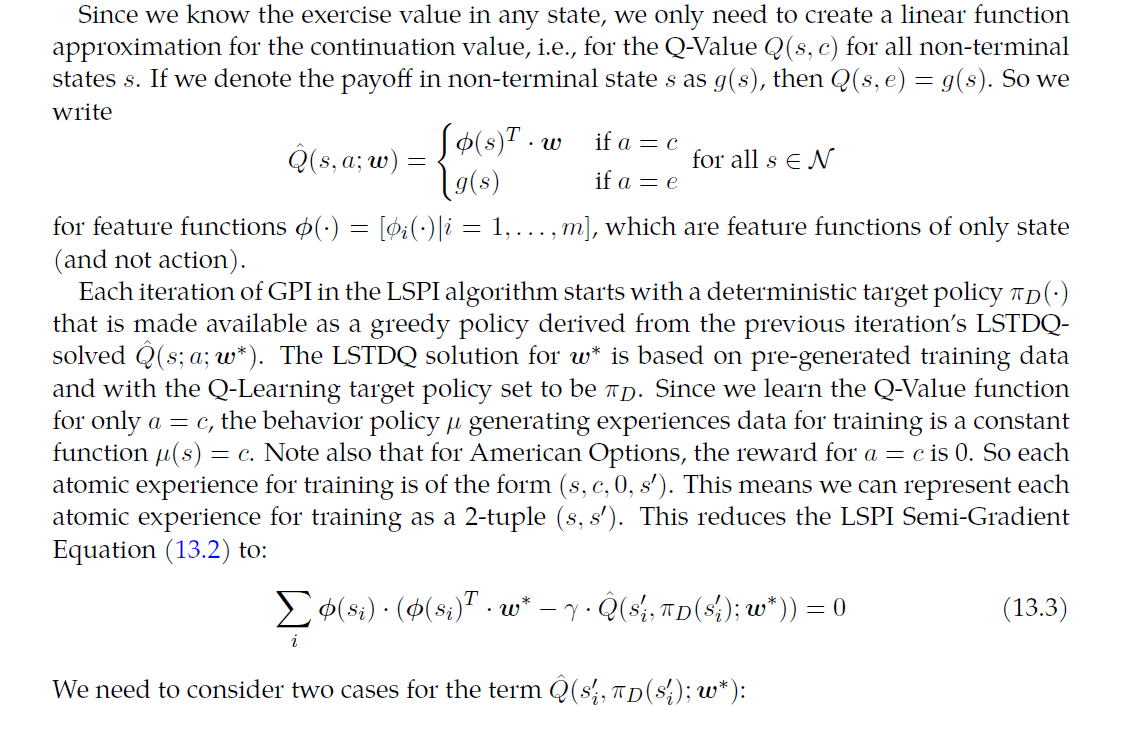

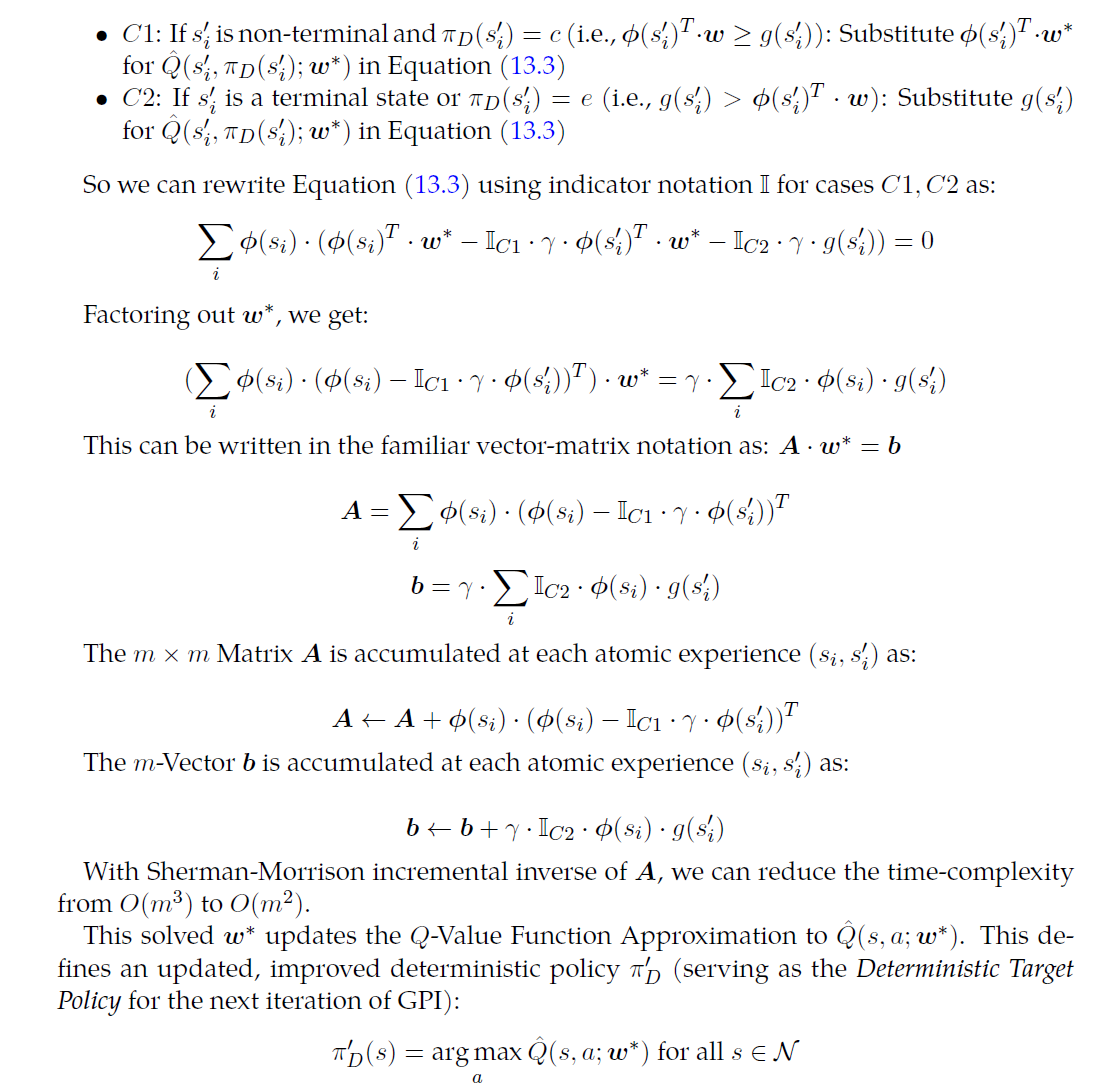

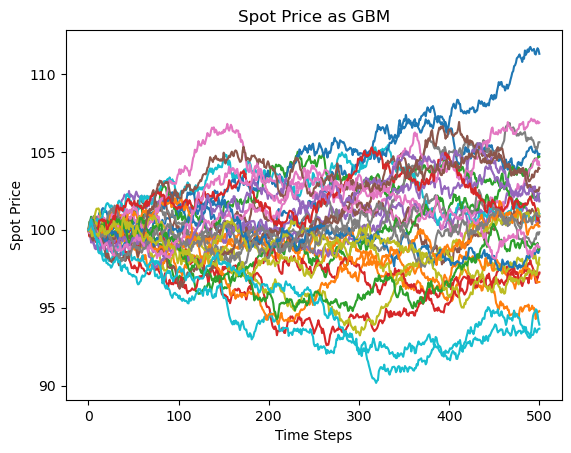

In [3]:
import matplotlib.pyplot as plt

num_paths = 30
num_steps = 500
dt = 0.0001
init = 100
mu = 0.1
sigma = 0.2
seed = 345

paths = GeometricBrownianMotion.simulate(
    init=init,
    mu=mu,
    sigma=sigma,
    dt=dt,
    num_steps=num_steps,
    num_paths=num_paths,
    seed=seed
)

plt.plot(paths)
plt.title('Spot Price as GBM')
plt.xlabel('Time Steps')
plt.ylabel('Spot Price')
plt.show()

In [4]:
import src.options as options
import datetime

# put_options = {
#     "ITM": options.AmericanOption(
#         option_type=options.OptionType.PUT,
#         underlying=options.Stock("AAPL", 100),
#         dividend_yield=None,
#         qty=1,
#         strike_price=105,
#         expiration_date=datetime.date.today() + datetime.timedelta(days=90),
#     ),
#     "ATM": options.AmericanOption(
#         option_type=options.OptionType.PUT,
#         underlying=options.Stock("AAPL", 100),
#         dividend_yield=None,
#         qty=1,
#         strike_price=100,
#         expiration_date=datetime.date.today() + datetime.timedelta(days=90),
#     ),
#     "OTM": options.AmericanOption(
#         option_type=options.OptionType.PUT,
#         underlying=options.Stock("AAPL", 100),
#         dividend_yield=None,
#         qty=1,
#         strike_price=95,
#         expiration_date=datetime.date.today() + datetime.timedelta(days=90),
#     ),
# }

put_options = {
        "test_1": options.AmericanOption(
        option_type=options.OptionType.PUT,
        underlying=options.Stock("GBM", 100),
        dividend_yield=None,
        qty=1,
        strike_price=100,
        expiration_date=datetime.date.today() + datetime.timedelta(days=90),
    )
}

In [5]:
def plot(ax, prices, xaxis, xlabel, ylabel, title):
    for (label, price) in prices:
        ax.plot(xaxis, price, label=label)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()

Computing OTM put options: 100%|█████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 21.13it/s]


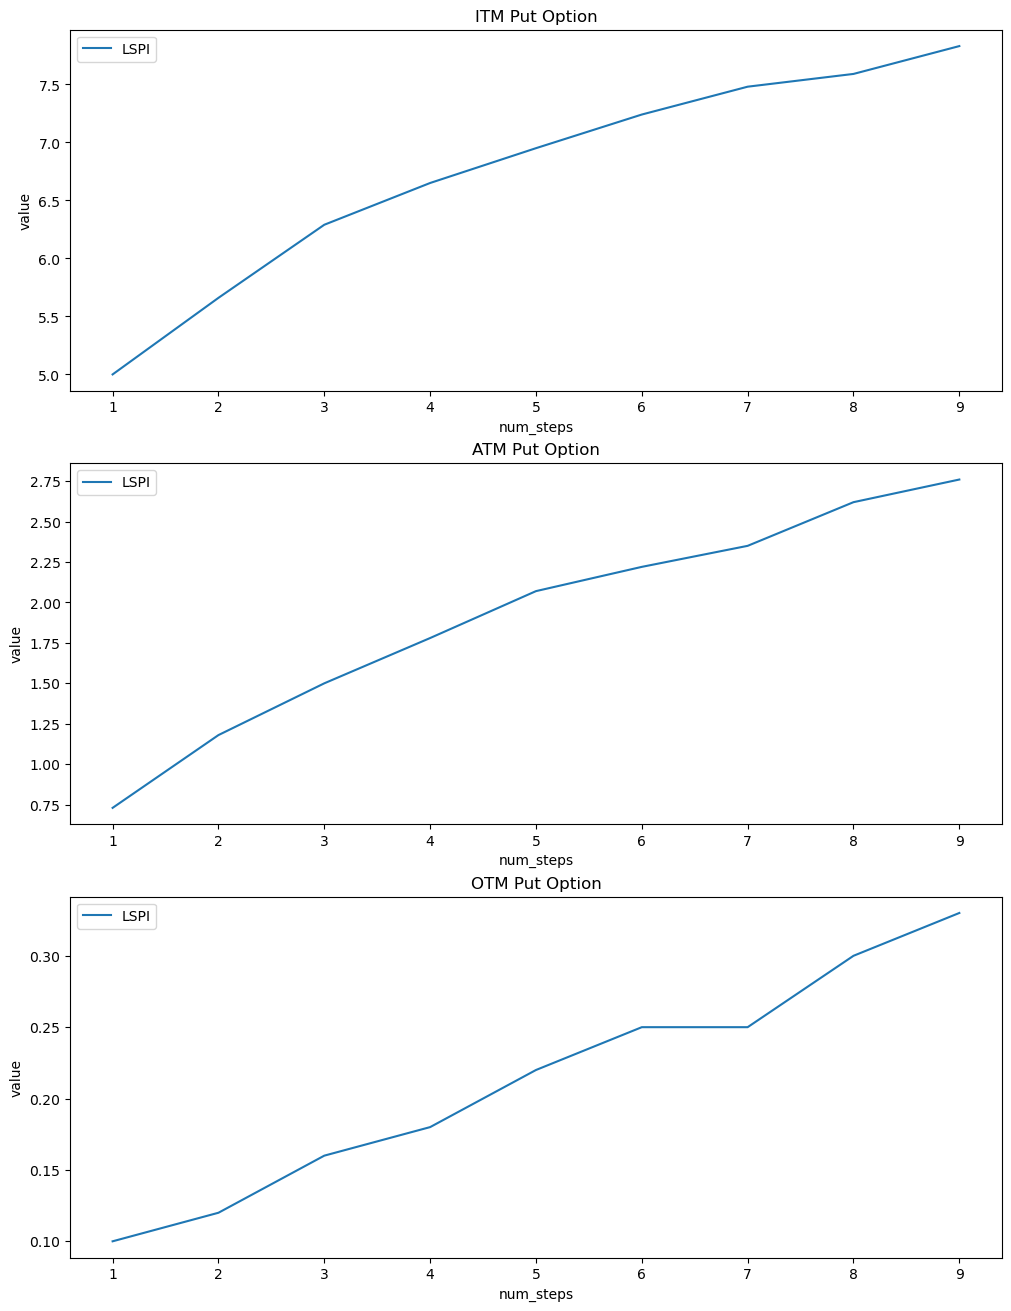

In [18]:
# from tqdm import tqdm

# def vary_num_steps(put_options, num_steps_range=range(1, 10, 1)): #10, 100, 5
#     fig, axes = plt.subplots(ncols=1, nrows=len(put_options), figsize=(2 * len(put_options) + 4, 3 * len(put_options) + 4), constrained_layout=True)
#     if len(put_options) == 1:
#         axes = [axes]

#     for i, (moneyness, option) in enumerate(put_options.items()):
#         ax = axes[i]
#         prices = []
#         xaxis = []
#         for num_steps in tqdm(num_steps_range, desc=f"Computing {moneyness} put options"):
#             current_price = price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=num_steps, seed = None)
#             prices.append(current_price)
#             xaxis.append(num_steps)
#         plot(ax, [('LSPI', prices)], xaxis, 'num_steps', 'value', f"{moneyness} Put Option")

#     plt.show()

# vary_num_steps(put_options)

Computing test_1 put options:   1%|▋                                                   | 4/299 [00:00<00:09, 31.01it/s]

(7, 7, 5000)
(7, 7, 5000)
(7, 7, 5000)
(7, 7, 5000)
(7, 7, 10000)
(7, 7, 10000)
(7, 7, 10000)
(7, 7, 10000)
(7, 7, 15000)
(7, 7, 15000)
(7, 7, 15000)
(7, 7, 15000)
(7, 7, 20000)
(7, 7, 20000)
(7, 7, 20000)
(7, 7, 20000)
(7, 7, 20000)
(7, 7, 25000)
(7, 7, 25000)
(7, 7, 25000)
(7, 7, 25000)
(7, 7, 25000)


Computing test_1 put options:   3%|█▍                                                  | 8/299 [00:00<00:15, 19.36it/s]

(7, 7, 30000)
(7, 7, 30000)
(7, 7, 30000)
(7, 7, 30000)
(7, 7, 30000)
(7, 7, 30000)
(7, 7, 35000)
(7, 7, 35000)
(7, 7, 35000)
(7, 7, 35000)
(7, 7, 35000)
(7, 7, 35000)
(7, 7, 40000)
(7, 7, 40000)
(7, 7, 40000)
(7, 7, 40000)
(7, 7, 40000)
(7, 7, 40000)
(7, 7, 45000)
(7, 7, 45000)
(7, 7, 45000)
(7, 7, 45000)
(7, 7, 45000)
(7, 7, 45000)
(7, 7, 50000)
(7, 7, 50000)
(7, 7, 50000)
(7, 7, 50000)
(7, 7, 50000)
(7, 7, 50000)
(7, 7, 55000)
(7, 7, 55000)
(7, 7, 55000)
(7, 7, 55000)


Computing test_1 put options:   4%|█▉                                                 | 11/299 [00:00<00:19, 14.89it/s]

(7, 7, 55000)
(7, 7, 55000)
(7, 7, 60000)
(7, 7, 60000)
(7, 7, 60000)
(7, 7, 60000)
(7, 7, 60000)
(7, 7, 60000)
(7, 7, 65000)
(7, 7, 65000)
(7, 7, 65000)
(7, 7, 65000)


Computing test_1 put options:   4%|██▏                                                | 13/299 [00:00<00:22, 12.95it/s]

(7, 7, 65000)
(7, 7, 65000)
(7, 7, 70000)
(7, 7, 70000)
(7, 7, 70000)
(7, 7, 70000)
(7, 7, 70000)
(7, 7, 70000)


Computing test_1 put options:   5%|██▌                                                | 15/299 [00:01<00:26, 10.52it/s]

(7, 7, 75000)
(7, 7, 75000)
(7, 7, 75000)
(7, 7, 75000)
(7, 7, 75000)
(7, 7, 75000)
(7, 7, 75000)
(7, 7, 80000)
(7, 7, 80000)
(7, 7, 80000)
(7, 7, 80000)
(7, 7, 80000)
(7, 7, 80000)


Computing test_1 put options:   6%|██▉                                                | 17/299 [00:01<00:31,  8.94it/s]

(7, 7, 80000)
(7, 7, 85000)
(7, 7, 85000)
(7, 7, 85000)
(7, 7, 85000)
(7, 7, 85000)
(7, 7, 85000)
(7, 7, 85000)


Computing test_1 put options:   6%|███                                                | 18/299 [00:01<00:34,  8.26it/s]

(7, 7, 90000)
(7, 7, 90000)
(7, 7, 90000)
(7, 7, 90000)
(7, 7, 90000)
(7, 7, 90000)
(7, 7, 90000)
(7, 7, 95000)
(7, 7, 95000)
(7, 7, 95000)


Computing test_1 put options:   6%|███▏                                               | 19/299 [00:01<00:36,  7.58it/s]

(7, 7, 95000)
(7, 7, 95000)
(7, 7, 95000)
(7, 7, 95000)
(7, 7, 100000)
(7, 7, 100000)
(7, 7, 100000)
(7, 7, 100000)
(7, 7, 100000)
(7, 7, 100000)


Computing test_1 put options:   7%|███▍                                               | 20/299 [00:02<00:40,  6.85it/s]

(7, 7, 100000)
(7, 7, 105000)
(7, 7, 105000)
(7, 7, 105000)
(7, 7, 105000)
(7, 7, 105000)
(7, 7, 105000)


Computing test_1 put options:   7%|███▌                                               | 21/299 [00:02<00:43,  6.37it/s]

(7, 7, 105000)
(7, 7, 110000)
(7, 7, 110000)
(7, 7, 110000)
(7, 7, 110000)
(7, 7, 110000)
(7, 7, 110000)


Computing test_1 put options:   7%|███▊                                               | 22/299 [00:02<00:47,  5.81it/s]

(7, 7, 110000)
(7, 7, 115000)
(7, 7, 115000)
(7, 7, 115000)
(7, 7, 115000)
(7, 7, 115000)


Computing test_1 put options:   8%|███▉                                               | 23/299 [00:02<00:52,  5.30it/s]

(7, 7, 115000)
(7, 7, 115000)
(7, 7, 120000)
(7, 7, 120000)
(7, 7, 120000)
(7, 7, 120000)
(7, 7, 120000)


Computing test_1 put options:   8%|████                                               | 24/299 [00:02<00:53,  5.17it/s]

(7, 7, 120000)
(7, 7, 120000)
(7, 7, 125000)
(7, 7, 125000)
(7, 7, 125000)
(7, 7, 125000)
(7, 7, 125000)


Computing test_1 put options:   8%|████▎                                              | 25/299 [00:03<00:55,  4.94it/s]

(7, 7, 125000)
(7, 7, 125000)
(7, 7, 130000)
(7, 7, 130000)
(7, 7, 130000)


Computing test_1 put options:   9%|████▍                                              | 26/299 [00:03<00:58,  4.69it/s]

(7, 7, 130000)
(7, 7, 130000)
(7, 7, 130000)
(7, 7, 130000)
(7, 7, 135000)
(7, 7, 135000)


Computing test_1 put options:   9%|████▌                                              | 27/299 [00:03<01:00,  4.51it/s]

(7, 7, 135000)
(7, 7, 135000)
(7, 7, 135000)
(7, 7, 135000)
(7, 7, 135000)
(7, 7, 140000)


Computing test_1 put options:   9%|████▊                                              | 28/299 [00:03<01:02,  4.36it/s]

(7, 7, 140000)
(7, 7, 140000)
(7, 7, 140000)
(7, 7, 140000)
(7, 7, 140000)
(7, 7, 140000)


Computing test_1 put options:  10%|████▉                                              | 29/299 [00:04<01:04,  4.22it/s]

(7, 7, 145000)
(7, 7, 145000)
(7, 7, 145000)
(7, 7, 145000)
(7, 7, 145000)
(7, 7, 145000)
(7, 7, 145000)


Computing test_1 put options:  10%|█████                                              | 30/299 [00:04<01:05,  4.09it/s]

(7, 7, 150000)
(7, 7, 150000)
(7, 7, 150000)
(7, 7, 150000)
(7, 7, 150000)
(7, 7, 150000)
(7, 7, 150000)


Computing test_1 put options:  10%|█████▎                                             | 31/299 [00:04<01:07,  3.98it/s]

(7, 7, 155000)
(7, 7, 155000)
(7, 7, 155000)
(7, 7, 155000)
(7, 7, 155000)
(7, 7, 155000)
(7, 7, 155000)


Computing test_1 put options:  11%|█████▍                                             | 32/299 [00:04<01:08,  3.88it/s]

(7, 7, 160000)
(7, 7, 160000)
(7, 7, 160000)
(7, 7, 160000)
(7, 7, 160000)
(7, 7, 160000)
(7, 7, 160000)


Computing test_1 put options:  11%|█████▍                                             | 32/299 [00:05<00:42,  6.34it/s]

(7, 7, 165000)
(7, 7, 165000)
(7, 7, 165000)


KeyboardInterrupt: 

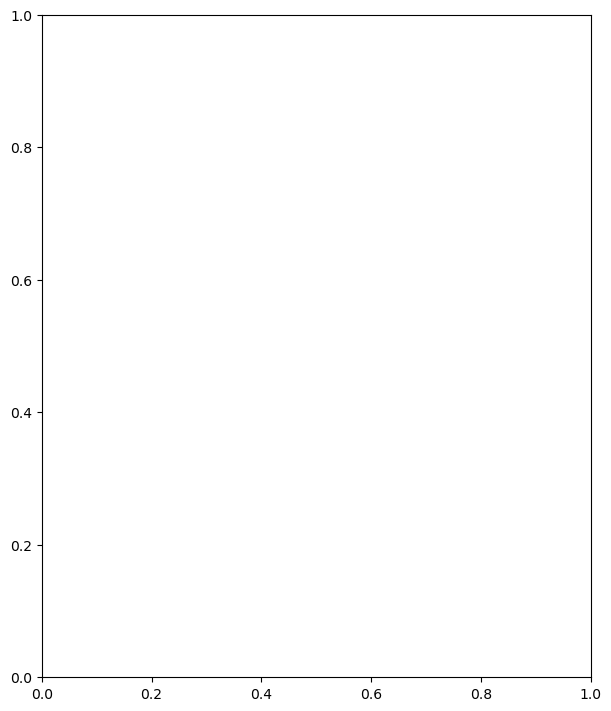

In [8]:
from tqdm import tqdm

def vary_num_steps(put_options, num_steps_range=range(1, 300, 1)): #10, 100, 5
    fig, axes = plt.subplots(ncols=1, nrows=len(put_options), figsize=(2 * len(put_options) + 4, 3 * len(put_options) + 4), constrained_layout=True)
    if len(put_options) == 1:
        axes = [axes]

    for i, (moneyness, option) in enumerate(put_options.items()):
        ax = axes[i]
        prices = []
        xaxis = []
        for num_steps in tqdm(num_steps_range, desc=f"Computing {moneyness} put options"):
            current_price = price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=num_steps, seed = None)
            prices.append(current_price)
            xaxis.append(num_steps)
        plot(ax, [('LSPI', prices)], xaxis, 'num_steps', 'value', f"{moneyness} Put Option")

    plt.show()

vary_num_steps(put_options)

Computing test_1 put options: 100%|██████████████████████████████████████████████████| 299/299 [06:38<00:00,  1.33s/it]


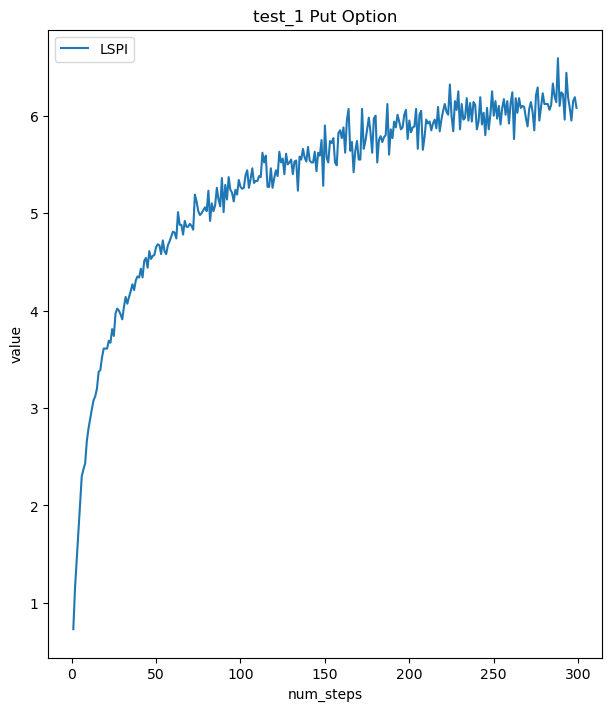

In [12]:
from tqdm import tqdm

def vary_num_steps(put_options, num_steps_range=range(1, 300, 1)): #10, 100, 5
    fig, axes = plt.subplots(ncols=1, nrows=len(put_options), figsize=(2 * len(put_options) + 4, 3 * len(put_options) + 4), constrained_layout=True)
    if len(put_options) == 1:
        axes = [axes]

    for i, (moneyness, option) in enumerate(put_options.items()):
        ax = axes[i]
        prices = []
        xaxis = []
        for num_steps in tqdm(num_steps_range, desc=f"Computing {moneyness} put options"):
            current_price = price_option(option, risk_free_rate=0.1, volatility=0.1, time_to_maturity_in_years=3/12, num_steps=num_steps, seed = None)
            prices.append(current_price)
            xaxis.append(num_steps)
        plot(ax, [('LSPI', prices)], xaxis, 'num_steps', 'value', f"{moneyness} Put Option")

    plt.show()

vary_num_steps(put_options)

__num_steps = 662-775 и num_paths = 50000 в оригинальной статьей по LSPi для результата лучше, чем Longstaff-Schwartz__

In [14]:
from src.samplers import GeometricBrownianMotionPutSampler
from src.american_monte_carlo import AmericanMonteCarlo
from src.basis_functions import PolynomialTransformer

amc = AmericanMonteCarlo(
    sampler=GeometricBrownianMotionPutSampler(
        cnt_trajectories=1_000_0,
        cnt_times=30,
        t=1,
        time_grid = None,
        seed = 345,
        sigma = 0.1,
        asset0=100.,
        strike=100.,
        mu=0.1
    ),
    basis_functions_transformer=PolynomialTransformer(),
    regularization_alpha=1e-4
)

 66%|######5   | 19/29 [00:00<00:00, 107.96it/s]

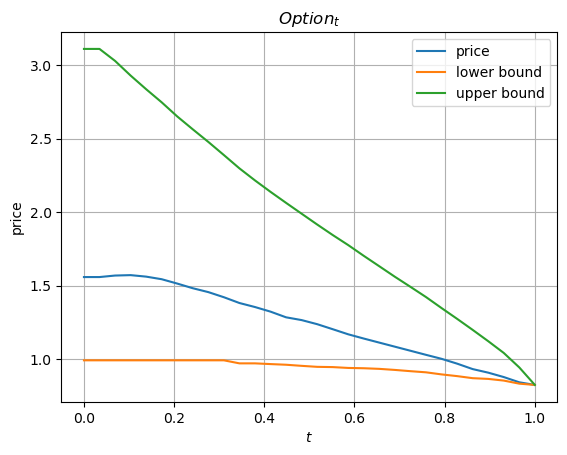

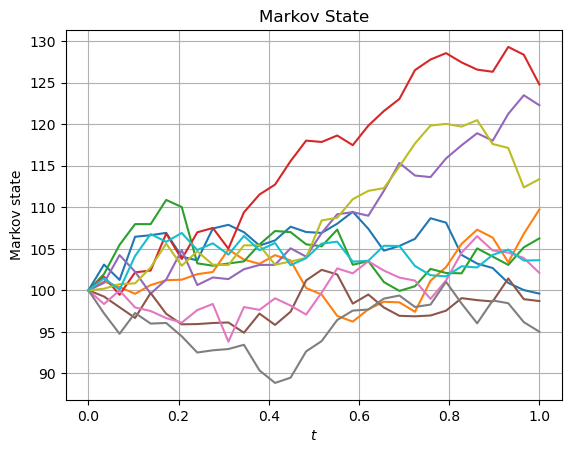

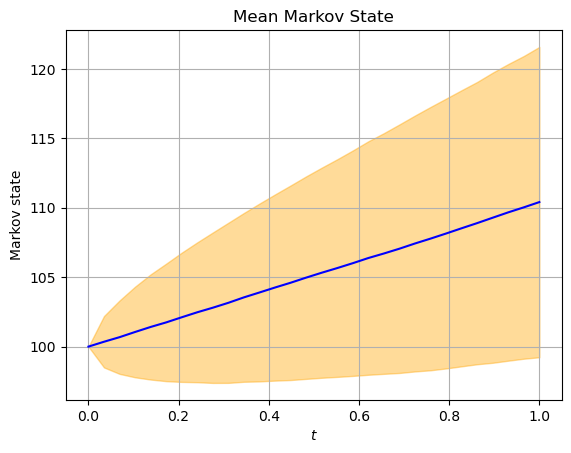

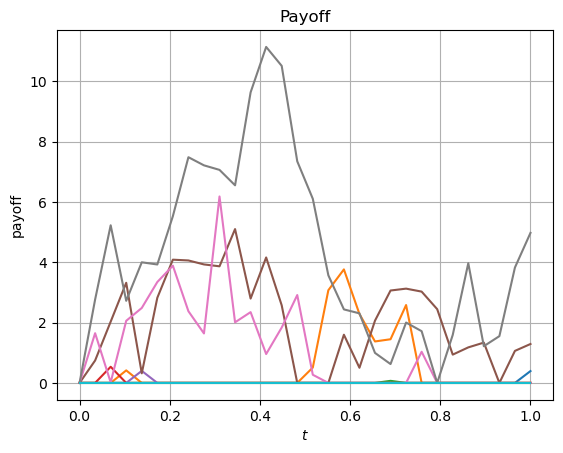

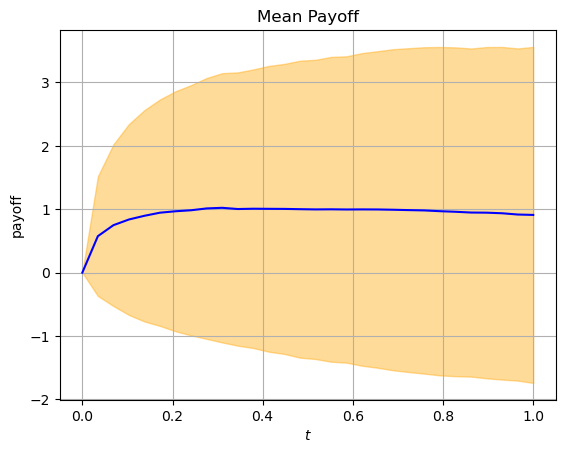

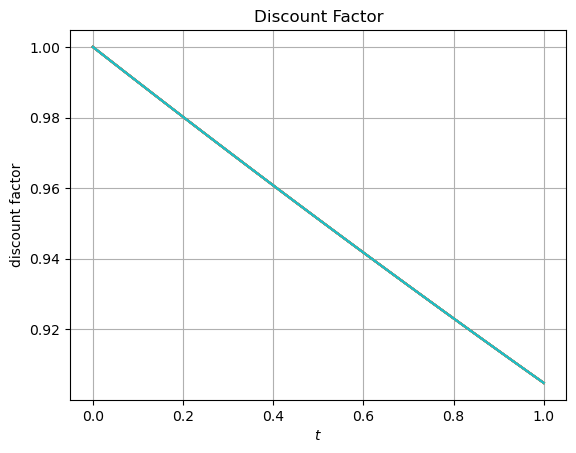

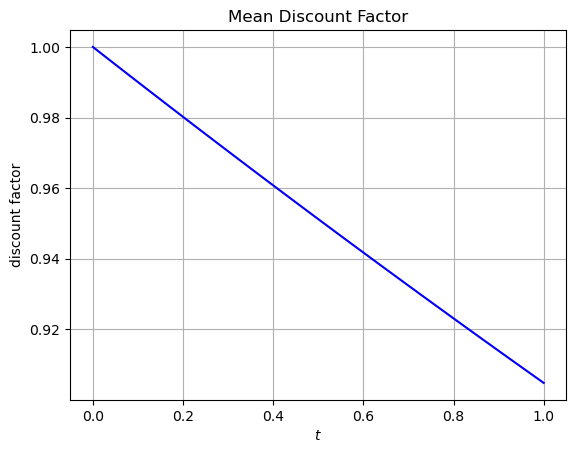

{'train': {'price': 1.5578754152544099,
  'upper_bound': 3.111657214905542,
  'lower_bound': 0.9907984185633415,
  'std': 1.9371493493117322}}

In [15]:
amc.price(
    test=False,
    quiet=False
)